# Geopandas

In [5]:
!apt-get install -qq curl g++ make

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  556k  100  556k    0     0   556k      0  0:00:01  0:00:01 --:--:--  415k


In [12]:
import os
os.chdir('spatialindex-src-1.8.5')

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'spatialindex-src-1.8.5'

In [13]:
!./configure

'.' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
!make

'make' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
!make install

'make' is not recognized as an internal or external command,
operable program or batch file.


In [16]:
!pip install rtree

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [17]:
!ldconfig

'ldconfig' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
!pip install geopandas

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [7]:
!mount -o remount,exec /content

'mount' is not recognized as an internal or external command,
operable program or batch file.


In [80]:
%matplotlib inline

import pandas as pd
import geopandas
import fiona
import rtree

pd.options.display.max_rows = 10

In [81]:
import fiona
import rtree

## Importando datos geoespaciales

La información geoespacial suele presentarse en archivos GIS como los shapefiles de ESRI, archivos GeoJSON, bases de PostGIS (es una extensión del motor PostgreSQL), etc.
Con GeoPandas se pueden leer muchos de estos archivos, interfaceando con la librería GDAL/OGR, usando la función geopandas.read_file.

Por otra parte, en muchos casos la información geográfica está disponible en campos de longitud y latitud en archivos .csv, para trabajar con ellos tenemos que leer primero la información en Pandas y luego generar un objeto Point que sí podrá ser leído por GeoPandas. Por último, como veremos a continuación, existen casos en los que la información está guardada en formato WKT (Well-Known Test).
Importemos a continuación la información de barrios de CABA.

In [82]:
barrios = pd.read_csv("barrios.csv", encoding='latin1')

In [83]:
barrios.head()

WKT            BARRIO  \
0  POLYGON ((-58.4528200492791 -34.5959886570639,...         CHACARITA   
1  POLYGON ((-58.4655768128541 -34.5965577078058,...          PATERNAL   
2  POLYGON ((-58.4237529813037 -34.5978273383243,...      VILLA CRESPO   
3  POLYGON ((-58.4946097568899 -34.6148652395239,...  VILLA DEL PARQUE   
4  POLYGON ((-58.4128700313089 -34.6141162515854,...           ALMAGRO   

   COMUNA    PERIMETRO          AREA  
0    15.0  7725.695228  3.118101e+06  
1    15.0  7087.513295  2.229829e+06  
2    15.0  8132.699348  3.613584e+06  
3    11.0  7705.389797  3.399596e+06  
4     5.0  8537.901368  4.050752e+06

In [84]:
def from_wkt(df, wkt_column):
    import shapely.wkt
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads)
    gdf = geopandas.GeoDataFrame(df, geometry='coordinates')
    return gdf
    

###GeoDataFrames: métodos y atributos

In [85]:
barrios = from_wkt(barrios, "WKT")

Los GeoDataFrame son objetos que tienen los mismos atributos que un Pandas DataFrame, con lo cual se puede manipular de datos a la que estamos acostumbrados. Como, por ejemplo, el método .plot()

In [86]:
type(barrios)

geopandas.geodataframe.GeoDataFrame

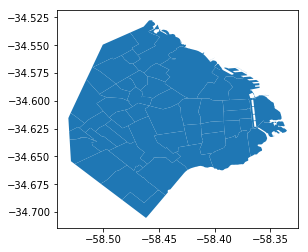

In [87]:
barrios.plot()

A diferencia del Pandas DataFrame, tiene un atributo que mantiene la información de la geometría.

In [88]:
barrios.geometry

0     POLYGON ((-58.4528200492791 -34.5959886570639,...
1     POLYGON ((-58.4655768128541 -34.5965577078058,...
2     POLYGON ((-58.4237529813037 -34.5978273383243,...
3     POLYGON ((-58.4946097568899 -34.6148652395239,...
4     POLYGON ((-58.4128700313089 -34.6141162515854,...
                            ...                        
43    POLYGON ((-58.4515941108325 -34.5315273335599,...
44    POLYGON ((-58.3952057970513 -34.5721906912083,...
45    POLYGON ((-58.3742728981345 -34.5787043103248,...
46    POLYGON ((-58.4566549786532 -34.5275529914205,...
47    POLYGON ((-58.3552004576535 -34.6194307028365,...
Name: coordinates, Length: 48, dtype: object

La librería shapely nos provee acceso a los objetos geométricos. Con ella podemos generar los objetos Point, Polygon y Line. Veamos un ejemplo.

Además, podemos especificar la proyección pasando el parámetro crs. Para ver cómo transformar una proyección se puede ir a: http://geopandas.readthedocs.io/en/latest/projections.html

In [89]:
from shapely.geometry import Point
p = Point(-58.396295, -34.591789) # Armo un punto a partir de dos coordenadas geográficas
df = pd.DataFrame(data = {'id': [1]}) # Armo un DataFrame
crs = {'init': 'epsg:4326'} # esta es la proyección más común
gdf = geopandas.GeoDataFrame(df,crs=crs, geometry=[p])

In [90]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=25)
plt.show();

Si quisiéramos podemos cambiar la proyección empleando el método .to_crs()
Para ello primero es necesario contar con un GeoDataFrame que tenga seteado un crs. Como vemos, **barrios** no lo tiene.

In [91]:
barrios.crs

Entonces, seteamos el crs como a continuación.

In [92]:
barrios.crs = {'init' :'epsg:4326'}

Ahora hagamos un plot de uno solo de los barrios, habiendo reproyectado el mapa. Nótese que hacemos indexing de la misma manera que en pandas.

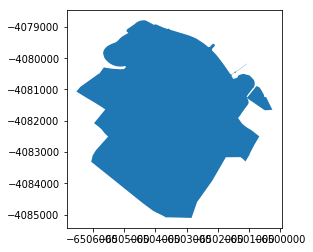

In [93]:
palermo = barrios[barrios["BARRIO"]=="PALERMO"]
palermo.to_crs(epsg = 3395).plot()

### Operaciones geográficas

En geopandas tenemos distintos métodos para realizar diferentes operaciones geográficas:
    - equals
    - contains
    - crosses
    - disjoint
    - overlaps
    - touches
    - within
    - covers
    - contains
    - intersects
    - intersection
    - union
    - unary_union
    - difference
    - overlay (difference, intersection, symmetric_difference) 
    - sjoin
    
    
En el siguiente link se tiene una referencia de varios de estos métodos, los heredados de shapely:
https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships

### Ejemplo. Locales bailables

In [94]:
locales = pd.read_csv("locales-bailables.csv", encoding='latin1')

In [95]:
locales

X          Y NUMERO_REGISTRO       NOMBRE                CALLE  \
0   -58.393750 -34.605027               1  CASTELBAMBA            RIOBAMBA    
1   -58.378510 -34.596003               2       GOLDEN           ESMERALDA    
2   -58.374727 -34.612002               3   REY CASTRO                PERU    
3   -58.390154 -34.605531               4    LA FRANCE           SARMIENTO    
4   -58.371747 -34.601950               5     BAHREIN              LAVALLE    
..         ...        ...             ...          ...                  ...   
156 -58.392393 -34.588431             155       AFRIKA                JUNIN   
157 -58.398014 -34.570538             156  ROSE IN RIO  AV. RAFAEL OBLIGADO   
158 -58.435554 -34.585813             157       INSIDE   AV. JUAN B. JUSTO    
159 -58.517859 -34.639008             158      FANTASY        AV. RIVADAVIA   
160 -58.429710 -34.550512             159  BNN(BANANA)  AV. RAFAEL OBLIGADO   

    NUMERO     DIRECCION_NORMALIZADA NUMERO_EXPEDIENTE      CAPACIDAD  CLASE  \
0      345             RIOBAMBA  345        4627093/18   428 personas    "C"   
1     1040           ESMERALDA  1040          10561/05   408 personas  "C.C"   
2      342                 PERU  342        4407796/18   901 personas    "C"   
3     1656           SARMIENTO  1656        3005915/18  1372 personas  "C.C"   
4      343              LAVALLE  343        2219876/18   880 personas    "C"   
..     ...                       ...               ...            ...    ...   
156   1787                JUNIN 1787       16728237/17   250 personas      C   
157   1221  AV. RAFAEL OBLIGADO 1221       19176186/17  1195 personas      C   
158   1579   AV. JUAN B. JUSTO  1579       17975651/17   376 personas    C.C   
159  10919       AV. RIVADAVIA 10919        8417777/14  1852 personas      C   
160   6201  AV. RAFAEL OBLIGADO 6201     9696828/2018    956 personas      C   

       ...    NUMERO_DISP_DE_RECHAZO FECHA_DISPOSICION_DE_RECHAZO  \
0      ...                       NaN                          NaN   
1      ...                       NaN                          NaN   
2      ...                       NaN                          NaN   
3      ...                       NaN                          NaN   
4      ...                       NaN                          NaN   
..     ...                       ...                          ...   
156    ...                       NaN                          NaN   
157    ...                       NaN                          NaN   
158    ...                       NaN                          NaN   
159    ...                       NaN                          NaN   
160    ...                       NaN                          NaN   

    NUMERO_DISPOSICION_DE_RECALCULO_CAPACIDAD FECHA_DISPOSICION_DE_CAPACIDAD  \
0                                         158            2005-12-12 00:00:00   
1                                          98            2005-08-08 00:00:00   
2                                          67            2006-04-24 00:00:00   
3                                         136            2005-09-29 00:00:00   
4                                          95            2007-11-06 00:00:00   
..                                        ...                            ...   
156                                        79            2017-08-17 00:00:00   
157                                       101            2017-10-25 00:00:00   
158                                        97            2017-10-18 00:00:00   
159                                        45            2018-03-28 00:00:00   
160                                        48            2018-04-13 00:00:00   

    FECHA_DE_ENTREGA_NUEVA_REVALIDA VENCIMIENTO       BARRIO     COMUNA  \
0                        2018-01-25  2018-04-13    Balvanera   Comuna 3   
1                               NaN         NaN       Retiro   Comuna 1   
2                        2018-05-31  2018-09-03    Monserrat   Comuna 1   
3            

Nótese que en este caso la información no viene en WKT sino que contamos con una columnas X (longitud) y una columna Y (latitud).

In [96]:
def from_x_y(df, x, y):
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[Point(xy) for xy in zip(df[x], df[y])])
    return gdf

In [97]:
locales = from_x_y(locales, "X", "Y")

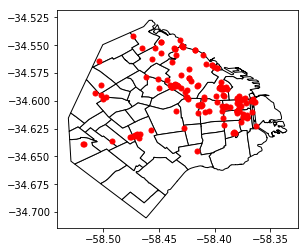

In [98]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
locales.plot(ax=ax, marker='o', color='red', markersize=25)
plt.show();

Tomemos dos locales:

In [99]:
local_a = locales.loc[0,"geometry"]

In [100]:
local_b = locales.loc[1, "geometry"]

In [101]:
from shapely.geometry import LineString
line = LineString([local_a, local_b])

In [102]:
barrios.BARRIO

0            CHACARITA
1             PATERNAL
2         VILLA CRESPO
3     VILLA DEL PARQUE
4              ALMAGRO
            ...       
43            BELGRANO
44            RECOLETA
45              RETIRO
46               NUÑEZ
47                BOCA
Name: BARRIO, Length: 48, dtype: object

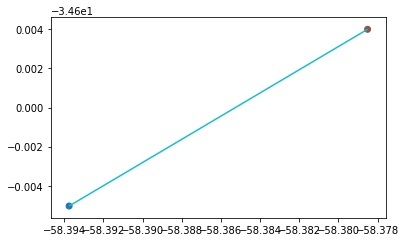

In [103]:
geopandas.GeoSeries([local_a, local_b, line]).plot(cmap='tab10')


In [104]:
balvanera = barrios.loc[barrios["BARRIO"]=="BALVANERA"]

Con el método **GeoDataFrame.contains** podemos ver si un polígono contiene un punto.

In [105]:
balvanera.contains(local_a)

24    True
dtype: bool

In [106]:
balvanera.contains(local_b)

24    False
dtype: bool

Si tomamos la línea de más arriba, podemos ver por qué barrios pasa empleando el método **GeoDataFrame.crosses**.

In [107]:
barrios[barrios.crosses(line)].BARRIO

24      BALVANERA
42    SAN NICOLAS
45         RETIRO
Name: BARRIO, dtype: object

### Ejemplo. Cuarteles y destacamentos de bomberos

In [108]:
bomberos = pd.read_csv("cuarteles-y-destacamentos-de-bomberos-de-policia-federal-argentina.csv", sep = ";")

In [109]:
bomberos.head()

ID        LAT        LNG                                     DCIA  \
0   1 -34.577526 -58.435809                          SECCION PALERMO   
1   2 -34.644895 -58.487654  SECCION RIESGO FORESTAL VELEZ SARSFIELD   
2   3 -34.630275 -58.435415                    SECCION GER CABALLITO   
3   4 -34.553318 -58.479216                     SECCION GER SAAVEDRA   
4   5 -34.613321 -58.388148  DIVISION CUARTEL I CORONEL J. M. CALAZA   

           TIPO CUARTEL                    GESTION    CALLE_OFIC INTERS  \
0  DESTACAMENTO     NaN  POLICIA FEDERAL ARGENTINA     GUATEMALA    NaN   
1  DESTACAMENTO     NaN  POLICIA FEDERAL ARGENTINA  RODO JOSE E.    NaN   
2  DESTACAMENTO     NaN  POLICIA FEDERAL ARGENTINA        RIGLOS    NaN   
3  DESTACAMENTO     NaN  POLICIA FEDERAL ARGENTINA     JARAMILLO    NaN   
4       CUARTEL       I  POLICIA FEDERAL ARGENTINA   BELGRANO AV    NaN   

   ALTURA             DIRECC       CPA        TEL             BARRIO  \
0  5966.0     5966 GUATEMALA  C1425BVP  4772-2222            PALERMO   
1  4474.0  4474 RODO JOSE E.  C1407HDR  4671-2222  PARQUE AVELLANEDA   
2   959.0         959 RIGLOS  C1424AFS  4921-2737   PARQUE CHACABUCO   
3  3551.0     3551 JARAMILLO  C1430AGC  4542-2222           SAAVEDRA   
4  1547.0   1547 BELGRANO AV  C1093AAD  4370-5858          MONSERRAT   

      COMUNA                                  OBSERVACION  
0  COMUNA 14                                          NaN  
1   COMUNA 9  BRIGADA ESPECIAL FEDERAL DE RESCATE (BEFER)  
2   COMUNA 7  BRIGADA ESPECIAL FEDERAL DE RESCATE (BEFER)  
3  COMUNA 12  BRIGADA ESPECIAL FEDERAL DE RESCATE (BEFER)  
4   COMUNA 1                                          NaN

In [110]:
bomberos = from_x_y(bomberos, "LNG","LAT")

In [111]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios.plot(ax=ax, color='white', edgecolor='black')
bomberos.plot(ax=ax, marker='o', color='red', markersize=25)
plt.show();

Imagínese que se desea bacer un análisis, suponiendo que cada delegación de bomberos tiene un alcance de hasta 1.5 km. Se desean obtener los lugares abarcados y los no abarcados por el servicio.
Para ello primero tendremos que convertir la proyección a una proyección que nos permita trabajar en metros.  Para la proyección  Gauss-Krueger Buenos Aires. 

Para obtener los datos de proyección se puede entrar a http://spatialreference.org/

In [112]:
barrios_gkba = barrios.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

In [113]:
bomberos_gkba = bomberos.to_crs(crs = "+proj=tmerc +lat_0=-34.629269 +lon_0=-58.4633 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs")

In [114]:
bomberos_gkba_buff = bomberos_gkba.copy()
bomberos_gkba_buff.geometry = bomberos_gkba.buffer(1500)

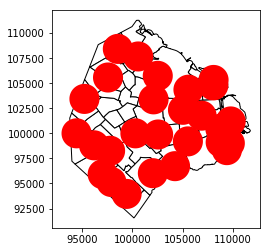

In [115]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios_gkba.plot(ax=ax, color='white', edgecolor='black')
bomberos_gkba_buff.plot(ax=ax, color='red')
plt.show();

In [116]:
intersection = geopandas.overlay(bomberos_gkba_buff, barrios_gkba, how = "intersection")

In [117]:
intersection.plot();

In [118]:
print("La cantidad total de metros que no están cubiertos por bomberos es:", intersection.area.sum())

La cantidad total de metros que no están cubiertos por bomberos es: 174983296.81559187


In [119]:
symm_difference = geopandas.overlay(bomberos_gkba_buff, barrios_gkba, how = "symmetric_difference")

In [120]:
symm_difference.plot();

In [57]:
print("La cantidad total de metros que no están cubiertos por bomberos es:", symm_difference.area.sum())
# Nota para ser precisos sería necesario quitar de los buffers la parte que queda afuera de CABA

La cantidad total de metros que no están cubiertos por bomberos es: 91798351.56261097


In [121]:
symm_difference2 = geopandas.overlay(barrios_gkba,bomberos_gkba_buff , how = "difference")

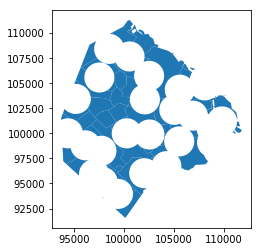

In [122]:
symm_difference2.plot();

In [123]:
print("La cantidad total de metros que no están cubiertos por bomberos es:", symm_difference2.area.sum())
# Nota para ser precisos sería necesario quitar de los buffers la parte que queda afuera de CABA

La cantidad total de metros que no están cubiertos por bomberos es: 69179093.47380497


Otro uso muy común en operaciones geográficas es el cálculo de una distancia. Además, otro caso es el cálculo del controide de un polígono.

Supongamos que se desea conocer cuáles son las 3 delegaciones de bomberos más cercanas a Palermo, para ello podemos:
    - Calcular el centroide
    - Calcula la distancia a todos los centros de bomberos
    - Quedarnos con los tres más cercanos

In [124]:
palermo = barrios_gkba[barrios_gkba["BARRIO"] == "PALERMO"].copy()
centroid = palermo.centroid

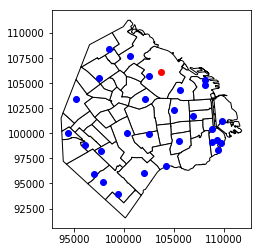

In [125]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
barrios_gkba.plot(ax=ax, color='white', edgecolor='black')
palermo.centroid.plot(ax=ax, color='red')
bomberos_gkba.plot(ax=ax, color='blue')
plt.show();

In [126]:
# Armamos un Point de shapely
centroid = Point(centroid.geometry.x, centroid.geometry.y)

In [127]:
type(bomberos_gkba)

geopandas.geodataframe.GeoDataFrame

In [128]:
distances = [ (i, pt.distance(centroid))  for i, pt in enumerate(bomberos_gkba.geometry)]
dist = [dist for i, dist in distances]
dist.sort()
closest = dist[0:3]

In [129]:
indexes = [i for i,j in distances if j in closest]

In [64]:
bomberos_gkba.iloc[indexes,:]

ID                              DCIA          TIPO CUARTEL  \
0    1                   SECCION PALERMO  DESTACAMENTO     NaN   
8    9      DIVISION CUARTEL IV RECOLETA       CUARTEL      IV   
11  12  DIVISION CUARTEL VI VILLA CRESPO       CUARTEL      VI   

                      GESTION  CALLE_OFIC INTERS  ALTURA           DIRECC  \
0   POLICIA FEDERAL ARGENTINA   GUATEMALA    NaN  5966.0   5966 GUATEMALA   
8   POLICIA FEDERAL ARGENTINA     LAPRIDA    NaN  1739.0     1739 LAPRIDA   
11  POLICIA FEDERAL ARGENTINA  CORRIENTES    NaN  5340.0  5340 CORRIENTES   

         CPA        TEL        BARRIO     COMUNA OBSERVACION  \
0   C1425BVP  4772-2222       PALERMO  COMUNA 14         NaN   
8   C1425EKO  4826-9222      RECOLETA   COMUNA 2         NaN   
11  C1414AJT  4854-2222  VILLA CRESPO  COMUNA 15         NaN   

                                       geometry  
0   POINT (102522.4944862011 105739.7710938063)  
8    POINT (105583.862304779 104356.7905254249)  
11  POINT (102101.6356713405 103393.2613214973)

## Visualización

Existen distintos paquetes para visualizar mapas entre las que se listan:
- Bokeh: https://bokeh.pydata.org/en/latest/docs/gallery/texas.html
- GeoViews (other interface to Bokeh/matplotlib): http://geo.holoviews.org
- Altair: https://altair-viz.github.io/gallery/choropleth.html
- Plotly: https://plot.ly/python/#maps


In [67]:
import folium

In [68]:
m = folium.Map([-34.606359, -58.443863], zoom_start=12, tiles="OpenStreetMap")
folium.GeoJson(barrios.to_json()).add_to(m)
folium.GeoJson(bomberos.to_json()).add_to(m)
m